# Bayesian regression for rating curve fitting
Joshua Simmons 2022

In this notebook, we will fit a Bayesian Linear Regression to rating curve data. Rating curves are a representation of the relationship between the water level in a river or stream, and the corresponding flow rate.

This model is of the form:

$$ Q = a H^{b}$$

- $H$ is the water level ($m$)
- $Q$ is the discharge ($m^3/s$)
- $a$ and $b$ are learnable model parameters.

To provide uncertainty alongside the model prediction, we will use the probabilistic programming language [NumPyro](https://numpyro.readthedocs.io/en/stable/) to fit a Bayesian Linear Regression.

In [1]:
import numpyro
from numpyro.infer import Predictive, MCMC, NUTS
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist

from jax import random
import jax.numpy as jnp

import arviz as az

import os
# if we are in docker
if os.name == 'posix':
    os.chdir('/project')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm

from functions import (plot_regression, draw_fit, plot_rc) 
rng_key_ = random.PRNGKey(1234)

## Load data
Load rating curve data and plot

In [2]:
# load the rc data
wl_gauge = 419084
os.chdir('/project')
rcdata_loc = './data/{}.xlsx'.format(wl_gauge)
rcdata = pd.read_excel(rcdata_loc)
rcdata.rename(
    columns={
        'MEAS_DATE':'date',
        'M_GH': 'water_level',
        'Discharge [m^3/s]': 'discharge'
    },
    inplace=True
)
rcdata['date'] = pd.to_datetime(rcdata.loc[:,'date'])
rcdata['year'] = rcdata['date'].dt.year
rcdata.head()

,date,water_level,discharge,FLOW,year
0,1994-07-12 08:30:00,0.573,0.029,2.5056,1994
1,1994-07-12 10:40:00,0.573,0.027,2.3328,1994
2,1994-07-15 14:00:00,0.603,0.064,5.5296,1994
3,1994-09-15 11:50:00,0.503,0.001,0.0864,1994
4,1995-01-23 11:50:00,1.585,7.176,620.0064,1995


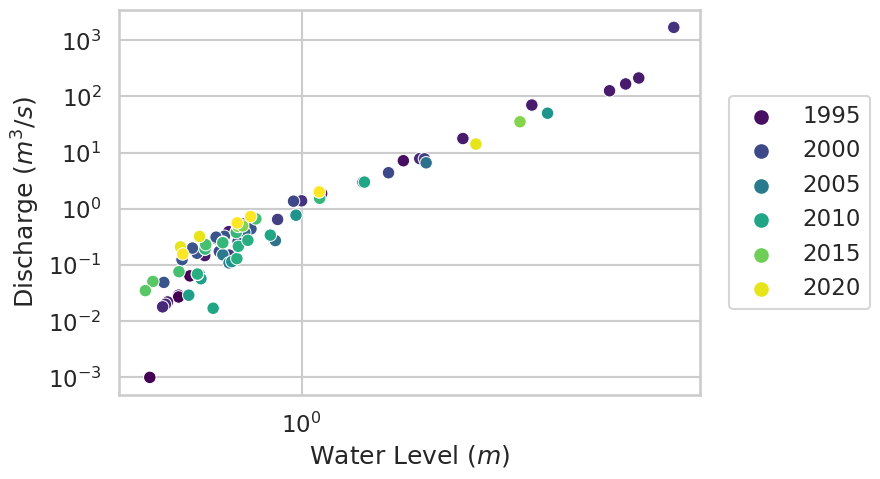

In [3]:
fig = plot_rc(rcdata,retfig=False)

## Standardise the data

First we will transform the points to be in log space so that instead of the equation:

$$ Q = a H^{b}$$

where $a$ and $b$ are the parameters we want to fit, we have:

$$log(Q) = log\left(a\right) + b * log(H)$$

where $\log(a)$ and $b$ are the parameters we want to fit (thanks to our handy friends the log laws).

We will then use `scipy.linear_model.LinearRegression` to fit a frequentist linear regression.

In [4]:
log_scale = True
X = rcdata.loc[:,['water_level']].values
y = rcdata.loc[:,['discharge']].values

# first we use a log transform to make the relationship linear 
# and errors more normally distributed
if log_scale:
    X = jnp.log(X).squeeze()
    y = jnp.log(y)

# make sure they're jax arrays
# X = jnp.concatenate([jnp.ones((X.shape[0],1)),jnp.array(X)], axis=-1)
X = jnp.array(X)
y = jnp.array(y).squeeze()

#Checks
print('X: ', X.shape)
print('y: ', y.shape)
print('X mean: {}'.format(X.mean()))
print('X std: {}'.format(X.std()))
print('y mean: {}'.format(y.mean()))
print('y std: {}'.format(y.std()))

X:  (82,)
y:  (82,)
X mean: -0.11234385520219803
X std: 0.5475943088531494
y mean: -0.7177249193191528
y std: 2.413806676864624


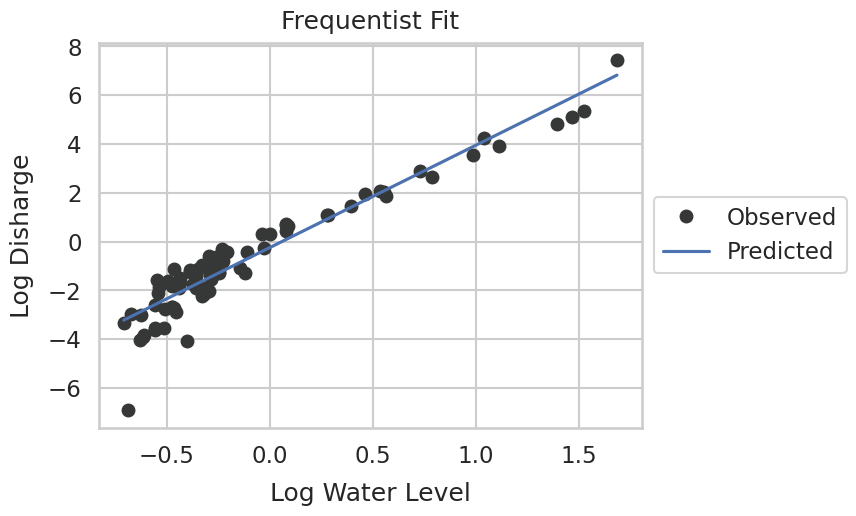

Linear model
Intercept: -0.246
Slope: 4.197


In [5]:
# fit a linear model to the data
freq_model = lm.LinearRegression(fit_intercept=True)
freq_model.fit(X.reshape(-1,1),y)
# get a sample_x for plotting a line and predict y
sample_x = np.linspace(X.min(),X.max(),101)
y_pred = freq_model.predict(sample_x.reshape(-1,1))

# Now draw the ft on both orginal scale and log-log
draw_fit(X,y,sample_x,y_pred=y_pred,log_scale=False)
print('Linear model\nIntercept: {:.3f}\nSlope: {:.3f}'.format(freq_model.intercept_,freq_model.coef_[0]))

## Fit a Bayesian Linear Regression using NumPyro

We will fit our Bayesian Linear Regression using NumPyro. Our model looks similar to before:
$$log(Q) = log\left(a\right) + b * log(H) + \epsilon$$
$$\epsilon \sim \mathcal{N}(0,\sigma)$$
but here we have explicitly stated that the model fits the data with some random residual or error ($\epsilon$). We can then model this error when fitting to the data, to take into account uncertainty.

We have to make some assumptions about the distribution of our residuals. In our case we will say they follow a normal distribution with a mean of zero (i.e., our linear model fit has no bias) and a standard deviation $\sigma$. $\sigma$ then becomes a third parameter that we will need to sample to determine the variance of our residuals after fitting the model. This is an okay assumption for our very simple case, give our data are in log space and that we don't want to think *too* hard about it for now. 

Now we have to adopt some priors (see above for links to resources on Bayesian approaches) for our three model parameters (we will ditch the log on $a$ for ease of notation).

$$a \sim ?$$
$$b \sim ?$$
$$\sigma \sim ?$$

We will visualise these further along to check them, but the main thing is trying to ensure that the range of predictions that our modles makes with these priors is reasonable. As an example, we wouldn't expect $b$ to be negative (so a normal distribution centered at zero would be a poor choice) as this would imply that as the water level increases, the discharge decreases! Otherwise, for this particular case we are going to keep our priors weakly informative, so that we don't have to think too hard.

NumPyro is a probabilistic programming language which helps us to implement a sampling scheme for the paramaters in our model ($log(a)$ and $b$). You can read more about NumPyro [here](https://num.pyro.ai/en/stable/getting_started.html).<br>
For an introduction to Bayesian methods, I thoroughly recommend Richard McElreath's [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) book (via kindle app [here](https://www.amazon.com.au/Statistical-Rethinking-Book-Bayesian-Examples-ebook/dp/B09RW8BYQR/ref=tmm_kin_swatch_0?_encoding=UTF8&qid=&sr=)) with associated code examples.

In [ ]:
def linear_model(water_level,discharge_observed=None):
    '''
    Define linear model with priors for the parameters and model error
    '''
    # Define priors
    # store the model prediction before we account for the error
    # and then finally sample so we can compare to our observations

Now lets sample from out prior distributions, check what these look like with arviz. You could also check what our predictions look like from the priors to ensure we aren't assuming anything too silly.

In [ ]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)
# here take 100 samples from our priors and make predictions on x_log
prior_samples = ?
prior_samples = {k: jnp.expand_dims(v,axis=0) for k, v in prior_samples.items()}
# and put this into arviz for easy plotting
arviz_priors = ?
arviz_priors

In [ ]:
plot_rc(rcdata,mu=prior_samples['mu'].squeeze())

In [ ]:
# and now plot the distributions and the simulated data
print('#'*80)
print('Priors')
priors_ax = ?
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

## MCMC Sampling

We will use the No U-Turn Sampler (NUTS) to sample from our posterior distributions. This sampler is popular in many PPLs (Stan, pymc, pyro) and should do the job for us with our mere three parameters. We will sample `num_samples` times form the posterior, with `num_warmup` samples taken and discarded before we start proper.

In [ ]:
# settings 
num_samples = 10000
num_warmup = int(0.25 * num_samples)
ci = 0.68

# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)

# define the sampler - No U-Turn Sampler (NUTS)
kernel = ?

# define the mcmc wrapper
mcmc_obj = ?

# now run the sampler for num_samples+burnin
?

# get the samples which will form our posterior
?

We will also get predcitive samples (simulations model + error) which will make more sense in the plots below. We add these to an arviz object for easy plotting and calculate the credible intervals.

In [ ]:
# get the samples for predictive uncertainty (our linear model + error)
posterior_predictive = ?

# get the mean model prediciton
mean_mu = jnp.mean(posterior_predictive['mu'], axis=0)
# hpdi is used to compute the credible intervals corresponding to ci
hpdi_mu = ?
hpdi_sim_y = ?

arviz_posterior = ?
arviz_posterior

Plot the posterior distributions for our three parameters and check that they look reasonable. We also want to check the traces (right hand plots) to ensure everything has gone well during the MCMC sampling. Again we won't worry too much about that for this fairly simple case. Notice as well how far our posteriors have deviated from our priors based on the data we have observed.

In [ ]:
print('#'*80)
print('Posterior')
?
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

## Plot the results

We can now plot our model predictions with uncertainty for our selected credible interval (`ci`) - say 68%. Notice that we plot two uncertainty bands, the first is the credible interval for our linear model (blue bands). Essentially, what are range of slopes and intercepts that linear fit could take, reflecting the posteriors for  parameters $a$ and $b$ as we are uncertain of their exact value. 

However, we also have the $\sigma$ parameter. The predictive uncertainty (credible interval given by the orange bands) incorporates model uncertainty and the error ($\epsilon$) which describes our data (which we have assumed to be of the form $\mathcal{N}(0,\sigma)$). 

Here we are simulating possible values of actual data points, as opposed to just the range of possible linear regression lines. This range reflects the discharge we could expect for a new event if measured by gauging, rather than our modelled prediction of discharge from water level. These bands should include approximately 68% of our data points, i.e. approximately matching the `ci` we have chosen.

In [ ]:
# Now we will plot the results of our fit
# We need to sort the results so our confidence intervals aren't wonky
sort_idx = jnp.argsort(X)
plot_regression(
    X,y,
    X[sort_idx],mean_mu[sort_idx], 
    hpdi_mu[:,sort_idx], hpdi_sim_y[:,sort_idx], 
    ci
)    